# Packages

In [15]:
from quocslib.optimalcontrolproblems.OneQubitProblem_2fields import OneQubit2Fields
import time, datetime

import scipy
import numpy as np
from scipy import linalg
import os
import sys
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import time
import copy as cp
from scipy import signal
# import necessary stuff from quidi
from logic.pulsed.pulse_objects import PulseBlock, PulseBlockEnsemble, PulseSequence
from user_scripts.Timo.own.optimalcontrol.oc_simlib import TimeDependentSimulation, SimParameters, ArbPulse, PredefinedArbPulses

import logging
logging.basicConfig(filename='logfile.log', filemode='w', level=logging.DEBUG)
logger = logging.getLogger(__name__)

0

0

# Library functions

In [22]:
def list_2_csv(in_list):
    str_list = ""
    
    if type(in_list) != list:
        in_list = [in_list]
        
    for el in in_list:
        str_list += f"{el}, "
    
    if len(str_list) > 0:
        str_list = str_list[:-2]
        
    return str_list

def dict_2_header_str(in_dict):
    out_str = ""
    for key, val in in_dict.items():
        out_str += f"{key}: {val}\n"
        
    return out_str

def get_pulse_filename(path, name="", name_ampl="amplitude.txt", name_phase="phase.txt"):
    return os.path.abspath(path + "/" + name + name_ampl), os.path.abspath(path + "/" + name + name_phase)

def save_pulse(path, data_ampl, data_phase, name="", name_ampl="amplitude.txt", name_phase="phase.txt"):
    header_dict = {}
    try:
        now = datetime.datetime.now() # current date and time
        header_dict['timestamp'] = now.strftime("%Y/%m/%d-%H:%M:%S")
        header_dict['script_parameters'] = script_params
        header_dict.update(opti_comm_dict['optimization_dictionary'])
        
        fname_ampl, fname_phase = get_pulse_filename(path, name=name, name_ampl=name_ampl, name_phase=name_phase)
        
        if data_ampl is not None:
            try:
                os.remove(fname_ampl)
            except IOError:
                pass
            np.savetxt(fname_ampl,  data_ampl,  header=dict_2_header_str(header_dict))
        if data_phase is not None:
            try:
                os.remove(fname_phase)
            except IOError:
                pass
            np.savetxt(fname_phase, data_phase, header=dict_2_header_str(header_dict))
    except:
        logger.exception("")

        
def save_optimization_result(path, name="opt_res_", name_ampl="amplitude.txt", name_phase="phase.txt"):
    try:
        # save fom by same function as pulse
        save_pulse(path, fom_all, None, name=name, name_ampl='fom.txt', name_phase='')
        
        optimizer_obj = optimizationlogic.optimization_obj
        best_dict = optimizer_obj.opt_alg_obj.get_best_controls()
        
        pulses_list = best_dict['pulses']
        time_grids_list = best_dict['timegrids']
        parameters_list = best_dict['parameters']
        
        t_amplitude = time_grids_list[0]
        amplitude = pulses_list[0]
        t_phase = time_grids_list[1]
        phase = pulses_list[1]

        data_ampl = np.column_stack((t_amplitude, amplitude))
        data_phase = np.column_stack((t_phase, phase))
        fom = np.column_stack((range(len(fom_all)), fom_all))

        save_pulse(path, data_ampl, data_phase, name=name, name_ampl=name_ampl, name_phase=name_phase)

    except:
        logger.exception("")
        
def interpolate_2_timegrid(pulse, timegrid_new, timegrid_unit='s'):
    amplitude_func = scipy.interpolate.interp1d(pulse.timegrid, pulse.get_data_ampl(unit=pulse.data_unit),
                                                fill_value=0, bounds_error=False)
    phase_func = scipy.interpolate.interp1d(pulse.timegrid, pulse.get_data_phase(unit=pulse.data_unit),
                                            fill_value=0, bounds_error=False)
    
    pulse_new = cp.deepcopy(pulse)
    if timegrid_unit != pulse.timegrid_unit:
        raise NotImplemented # may rescale the old pulse first
    if timegrid_new[-1] < pulse.timegrid[-1]:
        # this would work, but probably not intended
        raise ValueError("Too short new timegrid would cut pulse.")
    
    pulse_new._data_ampl = amplitude_func(timegrid_new - timegrid_new[0])
    pulse_new._data_phase = phase_func(timegrid_new - timegrid_new[0])
    pulse_new._timegrid_ampl = timegrid_new
    pulse_new._timegrid_phase = timegrid_new
    
    # invalidate old data fields
    pulse_new._folder = None
    pulse_new._file = None
    pulse_new._file_ampl = None
    pulse_new._file_phase = None
    
    return pulse_new


In [29]:
# shaddows philipp_optimization.ipynb

def calculate_rho(rho_data):
    rho_data[2] = (rho_data[2] - 0.5) * 2
    rho_data[3] = (rho_data[3] - 0.5) * 2
    
    rho_return = np.zeros([2,2], dtype = complex)
    rho_return[0,0] = 1/2 + 1/2 * (rho_data[0] - rho_data[1])
    rho_return[0,1] = 1/2 * (rho_data[3] + 1j * rho_data[2])
    rho_return[1,0] = 1/2 * (rho_data[3] - 1j * rho_data[2])
    rho_return[1,1] = 1/2 - 1/2 * (rho_data[0] - rho_data[1])
    
    return rho_return

def rho_min(rho):
    #find a physically correct density matrix
    
    sigma = np.zeros((2,2))
    # substitute constant values; rho[0,0]) and rho[1,1] are always real!
    a = np.real(1 + (-1 + rho[0,0]) * rho[0,0] + (-1 + rho[1,1]) * rho[1,1] + 2 * np.abs(rho[0,1]))**2
    b = np.real(-rho[0,0] + rho[1,1])
    c = -2 * np.real(rho[0,1])
    d = - 2 * np.imag(rho[0,1])

    n1 = np.arctan2([-c] , [-b])
    n1 = n1[0]
    n2 = np.arctan2([c], [b])
    n2 = n2[0]
    x1 = -np.arccos(- np.sqrt((b**2 + c**2)/(b**2 + c**2 + d**2)))
    x2 = np.arccos(- np.sqrt((b**2 + c**2)/(b**2 + c**2 + d**2)))

    sigma[0,0] = a + b * np.cos(n1) * np.cos(x1) + c * np.cos(x1) * np.sin(n1) + d * np.sin(x1)
    sigma[0,1] = a + b * np.cos(n1) * np.cos(x2) + c * np.cos(x2) * np.sin(n1) + d * np.sin(x2)
    sigma[1,0] = a + b * np.cos(n2) * np.cos(x1) + c * np.cos(x1) * np.sin(n2) + d * np.sin(x1)
    sigma[1,1] = a + b * np.cos(n2) * np.cos(x2) + c * np.cos(x2) * np.sin(n2) + d * np.sin(x2)

    pos_min = np.unravel_index(np.argmin(sigma), np.shape(sigma))
    n_min = int(pos_min[0])
    x_min = int(pos_min[1])

    if n_min == 0 and x_min == 0:
        rho_return = rho_parameterized(n1,x1)
    elif n_min == 0 and x_min == 1:
        rho_return = rho_parameterized(n1,x2)
    elif n_min == 1 and x_min == 0:
        rho_return = rho_parameterized(n2,x1)
    elif n_min == 1 and x_min == 1:
        rho_return = rho_parameterized(n2,x2)
        
    return rho_return

def rho_phy_corr(rho):
    # enforces trace=1
    rho_corr = (rho + np.matrix.getH(rho))/2
    rho_corr = rho_corr/np.trace(rho_corr)
    return rho_corr    

def calc_chi(rho0_chi,rho1_chi,rho2_chi,rho3_chi):
    #"Quantum State Tomography: calculate matrix Chi from given density matrices rho1,..,rho4"
    sigx = np.array([[0,1],[1,0]])

    #Defintion of Matrix M

    M=np.zeros([8,8],dtype=complex)
    M[0,0]=0
    M[0,1]=0
    M[0,2]=0
    M[0,3]=0
    M[0,4]=0
    M[0,5]=0
    M[0,6]=1
    M[0,7]=0

    M[1,0]=0
    M[1,1]=0
    M[1,2]=0
    M[1,3]=0
    M[1,4]=0
    M[1,5]=0
    M[1,6]=0
    M[1,7]=1

    M[2,0]=1
    M[2,1]=0
    M[2,2]=0
    M[2,3]=0
    M[2,4]=0
    M[2,5]=0
    M[2,6]=0
    M[2,7]=0

    M[3,0]=0
    M[3,1]=1
    M[3,2]=0
    M[3,3]=0
    M[3,4]=0
    M[3,5]=0
    M[3,6]=0
    M[3,7]=0

    M[4,0]=0.5
    M[4,1]=0
    M[4,2]=-0.5j
    M[4,3]=0
    M[4,4]=0.5j
    M[4,5]=0
    M[4,6]=0.5
    M[4,7]=0

    M[5,0]=0
    M[5,1]=0.5
    M[5,2]=0
    M[5,3]=-0.5j
    M[5,4]=0
    M[5,5]=0.5j
    M[5,6]=0
    M[5,7]=0.5

    M[6,0]=0.5
    M[6,1]=0
    M[6,2]=-0.5
    M[6,3]=0
    M[6,4]=-0.5
    M[6,5]=0
    M[6,6]=0.5
    M[6,7]=0

    M[7,0]=0
    M[7,1]=0.5
    M[7,2]=0
    M[7,3]=-0.5
    M[7,4]=0
    M[7,5]=-0.5
    M[7,6]=0
    M[7,7]=0.5

    #calculate inverse of matrix M
    Minv = np.linalg.inv(M)
    
    #convert matrices rho1,...,rho4 to one 8x2 matrix
    rho_chi=np.zeros([8,2],dtype=complex)
    rho_chi[0,0]=rho0_chi[0,0]
    rho_chi[0,1]=rho0_chi[0,1]
    rho_chi[1,0]=rho0_chi[1,0]
    rho_chi[1,1]=rho0_chi[1,1]

    rho_chi[2,0]=rho1_chi[0,0]
    rho_chi[2,1]=rho1_chi[0,1]
    rho_chi[3,0]=rho1_chi[1,0]
    rho_chi[3,1]=rho1_chi[1,1]

    rho_chi[4,0]=rho2_chi[0,0]
    rho_chi[4,1]=rho2_chi[0,1]
    rho_chi[5,0]=rho2_chi[1,0]
    rho_chi[5,1]=rho2_chi[1,1]

    rho_chi[6,0]=rho3_chi[0,0]
    rho_chi[6,1]=rho3_chi[0,1]
    rho_chi[7,0]=rho3_chi[1,0]
    rho_chi[7,1]=rho3_chi[1,1]
    
    #Minv times rho
    rhoprime = np.matmul(Minv,rho_chi)
    #convert rhoprime (8x2) into a 4x4 matrix
    rhoM=np.zeros([4,4],dtype=complex)
    rhoM[0:2,0:2]=rhoprime[0:2,0:2]
    rhoM[0:2,2:4]=rhoprime[2:4,0:2]
    rhoM[2:4,0:2]=rhoprime[4:6,0:2]
    rhoM[2:4,2:4]=rhoprime[6:9,0:2]
    
    #Definition of Lambda
    Lambda=np.zeros([4,4],dtype=complex)
    Lambda[0:2,0:2]=np.identity(2)
    Lambda[2:4,0:2]=sigx
    Lambda[0:2,2:4]=sigx
    Lambda[2:4,2:4]=-np.identity(2)
    Lambda = Lambda * 0.5
    
    #calculate Chi
    chi = np.matmul(Lambda,np.matmul(rhoM,Lambda))                    
    
    return chi


def fidelity_chi_pi_x(chi):
    #"calculate fidelity of Sx pi-pulse"
    #Definition of pauli and spin matrices
    sigx = np.array([[0,1],[1,0]])
    sigy = np.array([[0,-1j],[1j,0]])
    sigz = np.array([[1,0],[0,-1]])

    Sx = 0.5 * sigx
    Sy = 0.5 * sigy
    Sz= 0.5 * sigz

    #initial state
    init1 = np.array([[0,0],[0,1]])
    init2 = np.array([[1,0],[0,0]])
    init3 = np.matmul(np.matmul(linalg.expm(-1j*np.pi/2*Sx),init1),linalg.expm(1j*np.pi/2*Sx))
    init4 = np.matmul(np.matmul(linalg.expm(-1j*np.pi/2*Sy),init1),linalg.expm(1j*np.pi/2*Sy))

    #time evolution operator
    U = linalg.expm(-1j * np.pi * Sx)

    #final state
    final1 = np.matmul(np.matmul(U,init1),U.conj().transpose())
    final2 = np.matmul(np.matmul(U,init2),U.conj().transpose())
    final3 = np.matmul(np.matmul(U,init3),U.conj().transpose())
    final4 = np.matmul(np.matmul(U,init4),U.conj().transpose())
    
    #calculate theoretical chi of Sx pi-pulse
    chi_theo = calc_chi(final1,final2,final3,final4)
    
    # calculate figure of merit = gate fidelity
    #fom = np.real(np.trace(np.matmul(chi_theo.conj().transpose(),chi)))
    fom = 1 - 1/4 * np.trace(np.sqrt(np.matmul((chi-chi_theo).conj().transpose(),(chi - chi_theo))))
    
    return fom

# QuOCS and Qudi with Noise

## Creation of the optimization dictionary

The optimization dictionary contains all the settings compulsory for the optimization algorithm in order to run a proper optimization.

In [36]:
optimization_client_name = "test_dCRAB_Noisy_2_control_fields"

optimization_dictionary = {"optimization_client_name": optimization_client_name,
                           'opti_algorithm_module': 'quocslib.optimalalgorithms.dCRABNoisyAlgorithm', 
                           'opti_algorithm_class': 'DCrabNoisyAlgorithm', 
                          }

Number of iteration and super-iterations

In [43]:
# Total number of dCRAB superiteration
super_iteration_number = 10000000
# Maximum number of iteration per super-iteration (in max_eval_total: maximale anzahl von evaluation steps gesamt)
maximum_function_evaluations_number = 500

To activate the drift compensation and the re-evaluation steps add

In [50]:
optimization_dictionary['algorithm_settings'] = {"algorithm_name": "dCRAB",
                                                 "super_iteration_number": super_iteration_number,
                                                 #"max_eval_total": super_iteration_number * maximum_function_evaluations_number,
                                                 "FoM_goal": 0.00001,
                                                 "total_time_lim": 48*60,  # minutes
                                                 "compensate_drift": {
                                                     "compensate_after_SI": True,
                                                     "compensate_after_minutes": 15
                                                 },
                                                 "random_number_generator":{
                                                     "seed_number":420   # todo: really fix a seed here?
                                                 },
                                                 #"re_evaluation": {
                                                     #"re_evaluation_steps": [0.3, 0.5, 0.51]
                                                 #}
}
optimization_dictionary['algorithm_settings'] 

{'algorithm_name': 'dCRAB', 'super_iteration_number': 10000000, 'FoM_goal': 1e-05, 'total_time_lim': 2880, 'compensate_drift': {'compensate_after_SI': True, 'compensate_after_minutes': 15}, 'random_number_generator': {'seed_number': 420}}

Settings for the inner algorithm used by dCRAB

In [57]:
optimization_dictionary['algorithm_settings']["dsm_settings"] = {'general_settings': {
                                                "dsm_algorithm_name": "NelderMead", 
                                                'is_adaptive': False
                                            }, 
                                            'stopping_criteria': {
                                                #"max_eval": 100,
                                                "time_lim": 300,  #min
                                                #"xatol": 1e-10, 
                                                #"frtol": 1e-10,
                                                "change_based_stop": {
                                                    "cbs_funct_evals": 500, 
                                                    "cbs_change": 0.01    # stop if slope below
                                                }
                                            }
}
optimization_dictionary['algorithm_settings']

{'algorithm_name': 'dCRAB', 'super_iteration_number': 10000000, 'FoM_goal': 1e-05, 'total_time_lim': 2880, 'compensate_drift': {'compensate_after_SI': True, 'compensate_after_minutes': 15}, 'random_number_generator': {'seed_number': 420}, 'dsm_settings': {'general_settings': {'dsm_algorithm_name': 'NelderMead', 'is_adaptive': False}, 'stopping_criteria': {'time_lim': 300, 'change_based_stop': {'cbs_funct_evals': 500, 'cbs_change': 0.01}}}}

### Times

In [64]:
t_rabi_rect = 39.3e-9  
pix_pulse = 1
t_oc_pulse = 150e-9 #1.0000000000000001e-07
n_timebins = 2000
#t_oc_pulse = timegrid_ampl[-1]
fac_oc_guess = 1.0 # make initial guess not too good, otherwise hard for optimizer

ampl_max = 0.25  # V
ampl_rect = 0.25  # V 


fac_oc_rect = t_oc_pulse/(0.5*t_rabi_rect/pix_pulse)
if fac_oc_rect  < 3:
    logger.warning(f"OC pulse should be >3x as long as rect, now: {t_oc_pulse/(0.5*t_rabi_rect/pix_pulse)}")

time_p = {'time_name': 'time_p', 'initial_value': t_oc_pulse} # pulse length
optimization_dictionary['times'] = [time_p]
ampl_oc_guess = fac_oc_guess*1/fac_oc_rect*ampl_rect

ampl_oc_guess, fac_oc_rect

(0.03275, 7.633587786259541)

### Parameters

In [71]:
optimization_dictionary['parameters'] = []

In [78]:
optimization_dictionary['times']

[{'time_name': 'time_p', 'initial_value': 1.5e-07}]

### Pulses

#### Generate from predefined function

Levitt composite pulse

In [1728]:


pulse = PredefinedArbPulses.generate_levitt(20e6, n_t=1000)
pulse._func_omega_mhz_2_ampl_v = lambda x: x/20*0.25

from scipy.ndimage import gaussian_filter1d
pulse._data_ampl = gaussian_filter1d(pulse._data_ampl, 5)
pulse._data_phase = gaussian_filter1d(pulse._data_phase, 5)

pulse.as_dict()



{'name': 'levitt_phi=0.0pi', 'folder': None, 'file': [], 'timegrid_unit': 'µs', 'data_unit': 'MHz', 'data_ampl': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+

Rect pulse

In [323]:
# pi pulse with fixed lentgh
pulse = PredefinedArbPulses.generate_rect_pi(20e6, n_t=n_timebins, t_pulse=t_oc_pulse)
# hard pi pulse with auto lentgh
#pulse = PredefinedArbPulses.generate_rect_pi(20e6, n_t=1000)
pulse._func_omega_mhz_2_ampl_v = lambda x: x/20*0.25

fname = 'dummy' # to make loadable below

pulse.as_dict()

{'name': 'rect_phi={phase/np.pi:.1f}pi', 'folder': None, 'file': [], 'timegrid_unit': 'us', 'data_unit': 'MHz', 'data_ampl': array([20., 20., 20., ...,  0.,  0.,  0.]), 'data_phase': array([0., 0., 0., ..., 0., 0., 0.]), 'timegrid_ampl': array([0.00000000e+00, 5.00250125e-05, 1.00050025e-04, ...,
       9.98999500e-02, 9.99499750e-02, 1.00000000e-01]), 'timegrid_phase': array([0.00000000e+00, 5.00250125e-05, 1.00050025e-04, ...,
       9.98999500e-02, 9.99499750e-02, 1.00000000e-01])}

array([ 0.0080104 ,  0.00892461,  0.00979468,  0.01061905,  0.01139623,
        0.0121248 ,  0.01280344,  0.0134309 ,  0.01400599,  0.01452764,
        0.01499483,  0.01540665,  0.01576226,  0.01606089,  0.01630188,
        0.01648465,  0.01660868,  0.01667356,  0.01667894,  0.01662457,
        0.01651026,  0.01633592,  0.01610151,  0.01580711,  0.01545283,
        0.01503888,  0.01456555,  0.01403318,  0.0134422 ,  0.01279312,
        0.01208648,  0.01132294,  0.0105032 ,  0.00962803,  0.00869829,
        0.00771488,  0.00667879,  0.00559107,  0.00445285,  0.00326531,
        0.00202971,  0.0007474 , -0.00058024, -0.00195173, -0.00336551,
       -0.00481996, -0.00631338, -0.00784401, -0.00940998, -0.01100937,
       -0.01264016, -0.01430027, -0.01598751, -0.01769964, -0.01943431,
       -0.02118911, -0.02296151, -0.02474893, -0.0265487 , -0.02835803,
       -0.0301741 , -0.03199397, -0.03381462, -0.03563295, -0.03744581,
       -0.03924992, -0.04104198, -0.04281858, -0.04457625, -0.04

#### Load initial guess from extern
... or with fname=None assume slow rect pulse.

In [85]:
#folder = r"C:\Software\qudi_data\optimal_control_assets"
folder = r"C:\Software\qudi_data\optimal_control_assets\20220725_2_lessClipping"
folder = r"C:\Software\qudi_data\optimal_control_assets\20220726_1_NV1_penalty_fac=1"

#fname =  r"on_nv=2_"
fname = r"opt_res_"

folder = r"C:\Software\qudi_data\optimal_control_assets\Reisser_MSc_pulse_1"
fname = r"Opt_Pulse_01_"

folder = r"C:\Software\qudi_data\optimal_control_assets\20220726_1_NV1_penalty_fac=1"
folder = r"C:\Software\qudi_data\optimal_control_assets\Reisser_MSc_pulse_1"
folder =  r"C:\Software\qudi_data\optimal_control_assets\20220727_1_guessFromReisserMsc"
folder = r"C:\Software\qudi_data\optimal_control_assets\20220817_1_guessFromReisserMsc_penalty_fac=100"
#fname =  r"on_nv=2_"
fname = r"opt_res_"
#fname = r"Opt_Pulse_01_"

pulse = ArbPulse.load_pulse(folder, fname, unit_t='s', unit_data='V',
                            func_ampl_v_2_omega_mhz=lambda x: x/0.25*20,
                            func_omega_mhz_2_ampl_v=lambda x: 1/(x/0.25*20))

#folder = r"C:\Software\qudi_data\optimal_control_assets\20220818_procTomo_fromWeak_1"
#fname = r"opt_res_"
#
#pulse = ArbPulse.load_pulse(folder, fname, unit_t='s', unit_data='V',
#                            func_ampl_v_2_omega_mhz=lambda x: x/0.25*25,
#                            func_omega_mhz_2_ampl_v=lambda x: 1/(x/0.25*25))


#pulse = ArbPulse.load_pulse(folder, fname, unit_t='s', unit_data='V')



# rescale amplitude if needed
# previous t_rabi/ current t_rabi
pulse._data_ampl  = 39.1/49.3*pulse._data_ampl
pulse._data_phase = 39.1/49.3*pulse._data_phase

# ONLY for loading Reisser pulse
#pulse = ArbPulse.load_pulse(folder, fname, unit_t='ns', unit_data='MHz',
#                            func_omega_mhz_2_ampl_v=lambda y: y/13.849* 0.25 * 13.849/20)

pulse.as_dict()

pulse.get_data_ampl(unit=pulse.data_unit)

array([0.05691914, 0.05628698, 0.05566474, ..., 0.00592362, 0.00555924,
       0.00519149])

### Set initial guess

In [120]:
fname=None

len_oc_pulse = optimization_dictionary['times'][0]['initial_value']
timegrid = np.linspace(0, len_oc_pulse, n_timebins)
        

if fname:
    try:        
        pulse = pulse
        pulse = interpolate_2_timegrid(pulse, timegrid)
        timegrid_ampl = pulse.get_timegrid(unit='s')
        
        if n_timebins != len(timegrid_ampl) or not np.isclose(len_oc_pulse,timegrid_ampl[-1]):
            raise RuntimeError(f"Timegrid of loaded init pulse ({timegrid_ampl[-1]}@{len(timegrid_ampl)})"
                                f"doesn't match settings ({len_oc_pulse}@{n_timebins}) after interpolation" 
                                f"Unexpected!")
    except:
        logger.exception("")
        fname = None
if fname:
    try:
        initial_guess_ampl = {'function_type': 'list_function', 'list_function': pulse.get_data_ampl(unit='V')}
        initial_guess_phase = {'function_type': 'list_function', 'list_function': pulse.get_data_phase(unit='V')}
    except:
        logger.exception("")
    # ATTENTION: ONLY FOR DEBUG
    #initial_guess_ampl = {'function_type': 'list_function', 'list_function': 1/1.4*pulse['data_ampl']}
    #initial_guess_phase = {'function_type': 'list_function', 'list_function': 1/1.4*pulse['data_phase']}
else:
    pulse = ArbPulse()
    pulse._timegrid_ampl = timegrid
    pulse._timegrid_phase = timegrid
    pulse._data_ampl = np.ones(timegrid.size)*ampl_oc_guess
    pulse._data_phase = np.ones(timegrid.size)*0
    pulse.timegrid_unit = 's'
    pulse.data_unit = 'V'
    
    initial_guess_ampl = {'function_type': 'lambda_function', 'lambda_function': f'lambda t: {ampl_oc_guess} + 0.0*t'}
    initial_guess_phase = {'function_type': 'lambda_function', 'lambda_function': f'lambda t: {0} + 0.0*t'}
    
initial_guess_ampl['function_type']

'lambda_function'

In [127]:
vec_number = 3   #2-3
upper_freq_lim = 12  #8


    
pulse_amplitude = {'pulse_name': 'Amplitude', 
                           'upper_limit':ampl_max, 
                           'lower_limit': -ampl_max, 
                           'bins_number': n_timebins, 
                           'time_name': 'time_p', 
                           'amplitude_variation': 0.5*ampl_oc_guess, # added to guess amp, to create 3 points for start simplex
                           'basis': {'basis_name': 'Fourier', 
                                     'basis_class': 'Fourier', 
                                     'basis_module': 'quocslib.pulses.basis.Fourier', 
                                     'basis_vector_number': vec_number, # number of frequencies within the below defined range
                                     'random_super_parameter_distribution': 
                                     {'distribution_name': 'Uniform', 'distribution_class': 'Uniform', 
                                           'distribution_module': 'quocslib.pulses.superparameter.Uniform', 
                                           'lower_limit': 0.0, 'upper_limit': upper_freq_lim} # number of oscillations within pulse
                                    }, 
                           'scaling_function': {'function_type': 'lambda_function', 'lambda_function': 'lambda t: 1.0 + 0.0*t'}, 
                           'initial_guess': initial_guess_ampl,
                           'shrink_ampl_lim': True
                          }

pulse_phase = {'pulse_name': 'Phase', 
               'upper_limit': ampl_max, 
               'lower_limit': -ampl_max, 
               'bins_number': n_timebins, 
               'time_name': 'time_p', 
               'amplitude_variation': 0.5*ampl_oc_guess, # added to guess amp, to create 3 points for start simplex
               'basis': {'basis_name': 'Fourier', 
                         'basis_class': 'Fourier', 
                         'basis_module': 'quocslib.pulses.basis.Fourier', 
                         'basis_vector_number': vec_number, # number of frequencies within the below defined range
                         'random_super_parameter_distribution': 
                         {'distribution_name': 'Uniform', 'distribution_class': 'Uniform', 
                               'distribution_module': 'quocslib.pulses.superparameter.Uniform', 
                               'lower_limit': 0.0, 'upper_limit': upper_freq_lim} # number of oscillations within pulse
                        }, 
               'scaling_function': {'function_type': 'lambda_function', 'lambda_function': 'lambda t: 1.0 + 0.0*t'}, 
               'initial_guess': initial_guess_phase,
               'shrink_ampl_lim': True
              }

optimization_dictionary['pulses'] = [pulse_amplitude, pulse_phase]

ampl_oc_guess

0.03275

#### Plot init guess

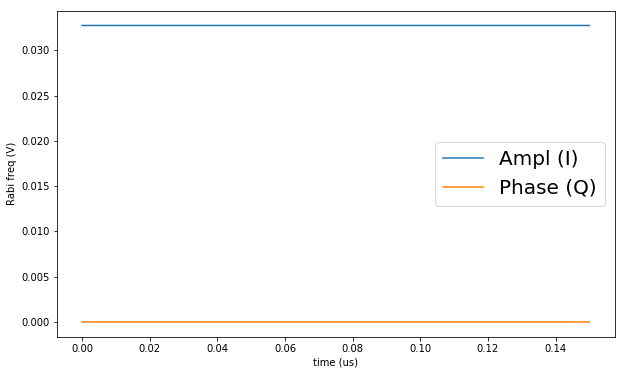

In [134]:
import matplotlib.pyplot as plt
    
t_amplitude = pulse.get_timegrid(unit='us')
amplitude = pulse.get_data_ampl(unit='V')
t_phase = pulse.get_timegrid(unit='us')
phase = pulse.get_data_phase(unit='V')

try:
    plt.figure(figsize=(10,6))
    plt.plot(t_amplitude, amplitude, label="Ampl (I)")
    plt.plot(t_phase, phase, label="Phase (Q)")
   # plt.plot(t_phase, phase+amplitude, label="I+Q")
    plt.ylabel("Rabi freq (V)")
    plt.xlabel("time (us)")
    plt.legend(loc='best', prop={'size': 20})
    plt.show()
except:
    logger.exception("")

### Init & Transfer to Qudi-QuOCS

In [183]:
opti_comm_dict = {"optimization_dictionary": optimization_dictionary}
optimizationlogic.load_opti_comm_dict(opti_comm_dict)

Press "Start" in the gui and see whether errors are logged.

Print the optimization dictionary also here. If the GUI is not showing the optimization dictionary, restart the Kernel.

In [190]:
optimalcontrol.opti_comm_dict

{'optimization_dictionary': {'optimization_client_name': 'test_dCRAB_Noisy_2_control_fields', 'opti_algorithm_module': 'quocslib.optimalalgorithms.dCRABNoisyAlgorithm', 'opti_algorithm_class': 'DCrabNoisyAlgorithm', 'algorithm_settings': {'algorithm_name': 'dCRAB', 'super_iteration_number': 10000000, 'FoM_goal': 1e-05, 'total_time_lim': 2880, 'compensate_drift': {'compensate_after_SI': True, 'compensate_after_minutes': 15}, 'random_number_generator': {'seed_number': 420}, 'dsm_settings': {'general_settings': {'dsm_algorithm_name': 'NelderMead', 'is_adaptive': False}, 'stopping_criteria': {'time_lim': 300, 'change_based_stop': {'cbs_funct_evals': 500, 'cbs_change': 0.01}}}}, 'times': [{'time_name': 'time_p', 'initial_value': 1.5e-07}], 'parameters': [], 'pulses': [{'pulse_name': 'Amplitude', 'upper_limit': 0.25, 'lower_limit': -0.25, 'bins_number': 2000, 'time_name': 'time_p', 'amplitude_variation': 0.016375, 'basis': {'basis_name': 'Fourier', 'basis_class': 'Fourier', 'basis_module': '

# Measurement

Run a normal rect Rabi with all analysis and MW generation parameters before. Then run with commented out the dicts below in order to keep all the respective pulsed settings.

In [155]:
script_params = {}
script_params['runtime_per_epoch'] = 4*40  # 5*60 s
script_params['readout_noise'] = np.sqrt(2)*0.01  # std_dev of fom, controls convergence in iteration
# for 40s of procTomo
script_params['readout_noise'] = 0.023 # for 4*40s

# needs to be smaller than the actual pulse length time_p due to the interpolation
script_params['length_oc'] = t_oc_pulse - 1e-9
script_params['is_noisy'] = True

# file paths 
folder_path = r'C:\Software\qudi_data\optimal_control_assets'
filename= "on_nv=2_"

script_params['readout_noise']

0.023

## Set measurement sequence and fom

In [162]:
def setup_sts_oc_pi(folder_path, filename, length_oc):
    dictparamsall = pulsedmasterlogic.generate_method_params
    
    dict_qst = dictparamsall["sts_oc"]
    dict_qst["experiment"] = 'sts_oc'
    dict_qst["name"] = 'stsoc'
    dict_qst["length"] = length_oc
    dict_qst["filename_amplitude"] = os.path.basename(get_pulse_filename(folder_path, name=filename)[0])
    dict_qst["filename_phase"] = os.path.basename(get_pulse_filename(folder_path, name=filename)[1])
    dict_qst["folder_path"] = folder_path
    

    
    return dict_qst

def setup_oc_npi(folder_path, filename, length_oc, n_start=1, n_step=1, n_n=4, t_gap=0e-9, phases_oc=[0],
                init_end_pix=0, init_end_phases_deg=[0]):
    dictparamsall = pulsedmasterlogic.generate_method_params
    
    dict_qst = dictparamsall["oc_nrep"]
    dict_qst["experiment"] = 'oc_nrep'
    dict_qst["name"] = 'oc_nrep'
    dict_qst["filename_amplitude"] = os.path.basename(get_pulse_filename(folder_path, name=filename)[0])
    dict_qst["filename_phase"] = os.path.basename(get_pulse_filename(folder_path, name=filename)[1])
    dict_qst["folder_path"] = folder_path
    
    dict_qst['n_start'] = n_start
    dict_qst['n_step'] = n_step
    dict_qst['t_gap'] = t_gap
    dict_qst['phases'] = list_2_csv(phases_oc)
    dict_qst['init_end_pix'] = init_end_pix
    dict_qst['init_end_phases_deg'] = list_2_csv(init_end_phases_deg)
    dict_qst['num_of_points'] = n_n
    
    dict_qst["alternating"] = True
    dict_qst["vs_rect_pulse"] = False
    
    
    return dict_qst

def setup_oc_proctomo(folder_path, filename, length_oc):
    dictparamsall = pulsedmasterlogic.generate_method_params
    
    dict_qst = dictparamsall["qst_state_oc"]
    dict_qst["experiment"] = 'qst_state_oc'
    dict_qst["name"] = 'qststateoc'
    dict_qst["length"] = length_oc
    dict_qst["filename_amplitude"] = os.path.basename(get_pulse_filename(folder_path, name=filename)[0])
    dict_qst["filename_phase"] = os.path.basename(get_pulse_filename(folder_path, name=filename)[1])
    dict_qst["folder_path"] = folder_path
    
    return dict_qst


def setup_fom_func_sts_oc_pi():
    def calc_fom():
        signal_data = pulsedmeasurementlogic.signal_data
        up_norm = signal_data[1,0] / signal_data[1,0]
        down_norm = signal_data[1,1] / signal_data[1,0]

        return np.real(1 - (up_norm - down_norm))
    
    return calc_fom


def setup_fom_func_oc_npi():
    def calc_fom():
        # signal_data[0,:] = xaxis
        # signal_data[1,:] = yaxis (alternating flattened)
        try:
            signal_data = pulsedmeasurementlogic.signal_data
            n_pi = signal_data[0,:]
            n_pi_even = np.where(n_pi%2==0)

            data_mw = signal_data[1,:]
            data_alt = signal_data[2,:]
            data_norm = data_mw/data_alt
            data_mw_0 = (data_norm)[n_pi%2==0]  # normed in state |0>
            data_mw_1 = (data_norm)[n_pi%2==1]  # normed in state |1>

            return np.mean(1 - (data_mw_0 - data_mw_1))
        except:
            return np.nan
    
    return calc_fom

def add_penalty_freq_bandstop(fom_func, f_res, f_center_block, df=10e6, n_f_sim=50, fac_penalty=1, symm_block=True):
    
 
    def get_f_sim_array(f_res, f_center_block, df, n_f, symm_block=False):
        f_center_block_mhz = f_center_block*1e-6
        f_res_mhz = f_res*1e-6
        df_mhz = df*1e-6
        if symm_block:
            delta_block = f_center_block_mhz - f_res_mhz
            f_center_2_mhz = f_res_mhz - delta_block
            f_centers = [f_center_block_mhz, f_center_2_mhz]
        else:
            f_centers = [f_center_block_mhz]

        freqs = []
        for f in f_centers:
            freqs.extend(list(np.linspace(f-df_mhz, f+df_mhz, int(n_f/len(f_centers)))))
        freq_array = np.asarray(freqs)

        return freq_array

    def extend_fom(pulse, func_volt_2_rabi=None):
        exp_fom = fom_func()

        # sim units are MHz!
        simp = SimParameters()


        B_gauss = (simp.D - f_res*1e-6)/ simp.gamma_nv

        # reloading pulse to make sure units are correct
        pulse = ArbPulse.load_pulse(pulse._folder, pulse.name, extension='txt',
                                     unit_t='s', unit_data='V', 
                                      func_ampl_v_2_omega_mhz=func_volt_2_rabi
                                      )

        try:
            sim = TimeDependentSimulation()
            
            freq_array = get_f_sim_array(f_res, f_center_block, df, n_f_sim, symm_block=symm_block)
            data_freq_detuning = sim.run_sim_fsweep(freq_array, pulse, B_gauss, simp)
            spin_pop = np.mean(data_freq_detuning)


        except Exception as e:
            logger.exception(f"Couldn't simulate pulse response: ")
            return np.nan

        # in the blockband, spin_pop should be uneffected (=1)
        fom_sim = (1 + fac_penalty*(abs(1-spin_pop)))
        fom_hybrid = exp_fom * fom_sim
        logger.debug(f"FOM: {fom_hybrid} <= Exp: {exp_fom}, Sim: {fom_sim},  factor= {fac_penalty}")
        logger.debug(f"Block bands: {freq_array}, nf= {len(freq_array)}")
        return fom_hybrid


    return extend_fom


def setup_fom_func_oc_proctomo():
    def calc_fom():
        signal_data = pulsedmeasurementlogic.signal_data

        E1 = signal_data[1,2:6]
        E0 = signal_data[1,6:10]
        E2 = signal_data[1,10:14]
        E3 = signal_data[1,14:18]

        # normalize the rabi measurments with m_s=0 and m_s=-1 state measurement
        norm_max = signal_data[1,0]
        norm_min = signal_data[1,1]

        E0 = (E0 - norm_min) / (norm_max-norm_min)
        E1 = (E1 - norm_min) / (norm_max-norm_min)
        E2 = (E2 - norm_min) / (norm_max-norm_min)
        E3 = (E3 - norm_min) / (norm_max-norm_min)

        # calculate the density matrices
        rho0 = calculate_rho(E0)
        rho1 = calculate_rho(E1)
        rho2 = calculate_rho(E2)
        rho3 = calculate_rho(E3)

        # quadratic maximum likelihood estimation of the density matrices
        rho0_est = rho_phy_corr(rho0)
        rho1_est = rho_phy_corr(rho1)
        rho2_est = rho_phy_corr(rho2)
        rho3_est = rho_phy_corr(rho3)

        # calculate chi matrix (Qunatum Process Tomography)
        chi = calc_chi(rho0_est,rho1_est,rho2_est,rho3_est)
        
        logger.debug(f"Reconstructed process matrix: {chi}")

        # calculate the fom
        fom = np.real(1 - fidelity_chi_pi_x(chi))
        
        return fom
        
    return calc_fom

script_params['fom_func_volt_2_rabi'] = None
qmeas = setup_sts_oc_pi(folder_path, filename, script_params['length_oc'])
qmeas = setup_oc_npi(folder_path, filename, script_params['length_oc'])
#qmeas = setup_oc_npi(folder_path, filename, script_params['length_oc'], t_gap=0.25/2.1e6, n_n=8)
qmeas = setup_oc_proctomo(folder_path, filename, script_params['length_oc'])

qmeas['optimize_time'] = 30*60

f_res = 2615e6
f_block = 2710e6
fom_func = setup_fom_func_oc_npi()
fom_func = setup_fom_func_oc_proctomo()

# add penalty to fom and register parameters
script_params['fom_func_volt_2_rabi'] = lambda y: y/ampl_rect*(1e-6/t_rabi_rect)
fom_func = add_penalty_freq_bandstop(fom_func, f_res, f_block, fac_penalty=10, symm_block=True)

script_params['generate_parameters'] = qmeas
script_params['fom_function'] = fom_func

qmeas



{'name': 'qststateoc', 'length': 1.49e-07, 'filename_amplitude': 'on_nv=2_amplitude.txt', 'filename_phase': 'on_nv=2_phase.txt', 'folder_path': 'C:\\Software\\qudi_data\\optimal_control_assets', 'experiment': 'qst_state_oc', 'optimize_time': 1800}

In [868]:
try:
    data = fom_func(pulse, script_params['fom_func_volt_2_rabi'])
except:
    logger.exception()
    
data

0.18968358948027036

In [873]:
# debug fom
try:
    data = add_penalty_freq_bandstop(fom_func, 2615e6, 2710e6)(pulse, func_volt_2_rabi=lambda y: y/0.25*20)
except:
    logger.exception("")
    
data

0.18968358948027036

In [55]:
#pulse = #folder = r"C:\Software\qudi_data\optimal_control_assets"
folder = r"C:\Software\qudi_data\optimal_control_assets\20220724_1"
fname = r"on_nv=2_"
fname = r"opt_pulse_"
n_bins_init_guess = 1001

pulse = TimeDependentSimulation.load_pulse(folder, fname, extension='txt',
                                           #func_volt_2_rabi=func_volt_2_rabi,
                                           func_t_2_us=lambda x: x*1e6)
pulse['timegrid_ampl'][-1]

In [160]:
signal_data = pulsedmeasurementlogic.signal_data
n_pi = signal_data[0,:]
data_mw = signal_data[1,:]
data_alt = signal_data[2,:]
data_norm = data_mw/data_alt
data_mw_0 = (data_norm)[n_pi%2==0]
data_mw_1 = (data_norm)[n_pi%2==1]

data_mw_1

array([0.843, 0.882, 0.896, 0.799])

In [618]:
try:
    a = fom_func()
except:
    logger.exception()
    
fom_func()

## Run

In [ ]:
laser_off()
######################################################################################################
# Parameters and Settings
######################################################################################################

# runtime of each experiment
runtime = script_params['runtime_per_epoch']
length_oc = script_params['length_oc'] 

# parameter to stop the experiment if its set to False in the console
pulsedmasterlogic.globalrun = True
uglobals.abort.clear()
logger.info("Starting new closed-loop quocs optimization")

# Dictonary containing the general measurement parameters for the predefined measurements
p_generation_dict = pulsedmasterlogic.generation_parameters
#p_generation_dict["laser_channel"] = "d_ch2" 
#p_generation_dict["sync_channel"] = "d_ch1" 
#p_generation_dict["gate_channel"] = None#"d_ch1" 
#p_generation_dict["microwave_channel"] = "a_ch1"
#p_generation_dict["microwave_amplitude"] = 0.25
#p_generation_dict["microwave_frequency"] = 2822.3e6
#p_generation_dict["rabi_period"] = 82.7e-9
#p_generation_dict["laser_length"] = 3e-06
#p_generation_dict["laser_delay"] = 0.2e-6
#p_generation_dict["wait_time"] = 1e-06
#p_generation_dict["analog_trigger_voltage"] = 0.0

# load the general measurement parameters for the predefined measurements
pulsedmasterlogic.set_generation_parameters(p_generation_dict)
script_params['pulsed_generation_params'] = pulsedmasterlogic.generation_parameters


# tell the measurement gui how the sequence looks
pulsed_settings = dict()
pulsed_settings['invoke_settings'] = True
pulsedmasterlogic.set_measurement_settings(pulsed_settings)
script_params['pulsed_settings'] = pulsed_settings


# make sure everything is finished
time.sleep(5)

# how the laser response is analyzed    
#pulsedmasterlogic.set_analysis_settings(method = 'mean')
#pulsedmasterlogic.set_analysis_settings(signal_start = 150e-9)
#pulsedmasterlogic.set_analysis_settings(signal_end = 1e-6)
#pulsedmasterlogic.set_extraction_settings(method = 'conv_deriv')

p_analysis_settings = pulsedmasterlogic.analysis_settings
p_extraction_settings = pulsedmasterlogic.extraction_settings
script_params['pulsed_analysis_settings'] = p_analysis_settings
script_params['pulsed_extraction_settings_settings'] = p_extraction_settings

# array to save the fom evolution
fom_all = []

# This section is devoted to the initialization in the pulsed logic and optimization logic of the main
# settings and parameters to be usde in the creation ofthe pulse sequence and the optimization
# Iteration, controls and figure of merit to compare with QuOCS
# Just an example for debug
args_dict = {"is_noisy": script_params['is_noisy']}
qubit = OneQubit2Fields(args_dict)

######################################################################################################
# Measurement
######################################################################################################
optimalcontrol.start_optimization()

# crucial, maybe it can be much shorter
time.sleep(1)

# Just a time to check for latent time
last_time_fom = time.time()
# repeat the whole process until its manually stopped or QuOCS finsihed the optimization
# Wait few seconds before starting to get and return data
while not optimizationlogic.handle_exit_obj.is_user_running:
    time.sleep(0.1)
    if (time.time() - last_time_fom) > 30 or uglobals.abort.is_set():
        logger.warning("Timeout or abort while initializing quocs.")
        uglobals.abort.set()
        break

# iteration number
it_val = 0

# when did the optimization start?
opt_start_time = time.time()
t_last_opt = 0
try:
    # print("Check before the loop starts: {0}".format(optimizationlogic.handle_exit_obj.is_user_running))
    while optimizationlogic.handle_exit_obj.is_user_running == True and not uglobals.abort.is_set():
        time_stamp=time.time()
        # wait until QuOCS optimizes the controls
        # print("Wait until the controls logic gives the controls")
        while not controlslogic.are_pulses_calculated:
            time.sleep(0.1)
            # If the waiting time exceed 10 seconds left stop the optimization
            if time.time() - last_time_fom > 20:
                logger.error("Too much time... Exit!")
                optimizationlogic.handle_exit_obj.is_user_running = False
                break

 
        #######################################################################################################
        # Get the Controls
        #######################################################################################################
        # Change the status of control calculations to avoid to evaluate the fom twice with the same controls
        controlslogic.are_pulses_calculated = False
        # Get the controls from the controls logic
        pulses, parameters, timegrids = controlslogic.pulses, controlslogic.parameters, controlslogic.timegrids
        #######################################################################################################
        # Perform the measurement
        #######################################################################################################

        # save the pulses as .txt files (predefined methods doesn't allow us to upload a numpy array as 
        # parameter)
        data_ampl = np.column_stack((timegrids[0], pulses[0]))
        data_phase = np.column_stack((timegrids[0], pulses[1]))
        save_pulse(folder_path, data_ampl, data_phase, name=filename)

        time.sleep(0.2)
        
        qmeas = cp.deepcopy(script_params['generate_parameters'])
        experiment = qmeas['experiment']
        exp_name = qmeas['name']
        try:
            optimize_time = qmeas['optimize_time'] 
        except KeyError:
            optimize_time = None
        qmeas.pop('optimize_time', None)
        qmeas.pop('experiment', None)
        # generate the sequence
        pulsedmasterlogic.generate_predefined_sequence(experiment,kwarg_dict=qmeas)  

        time.sleep(1)

        # upload the sequence
        pulsedmasterlogic.sample_ensemble(exp_name,True)
        while pulsedmasterlogic.status_dict['sampload_busy'] or pulsedmasterlogic.status_dict['sampling_ensemble_busy'] or pulsedmasterlogic.status_dict['loading_busy']:     
            time.sleep(1)

        #print('Finished uploading', dictparams_oc["name"], '!')

        # make sure everything is finished (crucial)
        #time.sleep(1)#time.sleep(5)  
        
        # optimize/track nv before mes
        if optimize_time:
            if time.time() - t_last_opt > optimize_time:
                laser_on()
                optimize_position()
                laser_off()
                t_last_opt = time.time()
        
         # start the measurement
        #print('Starting the measurement!')
        pulsedmasterlogic.toggle_pulsed_measurement(True)
        time.sleep(1)

        # make sure the measurement started
        while not pulsedmasterlogic.status_dict['measurement_running']:
            time.sleep(0.1)

        measurement_start_time = time.time()

        while time.time() <= measurement_start_time + runtime:
            time.sleep(0.2)

            # option to stop the measurement
            if pulsedmasterlogic.globalrun == False or uglobals.abort.is_set():
                print('Stopping the measurement!')
                break

        # option to stop the measurement
        if pulsedmasterlogic.globalrun == False or uglobals.abort.is_set():
            print('Stopping the measurement!')
            pulsedmasterlogic.toggle_pulsed_measurement(False)
            break

        #time.sleep(1)

        # Stop the measurement
        pulsedmasterlogic.toggle_pulsed_measurement(False)
        time_stamp_mes =time.time()

        # Make sure it stopped (Wait until the Picoscope card sends the data)
        while pulsedmasterlogic.status_dict['measurement_running']:
            time.sleep(0.1)

        #######################################################################################################
        # Analysis
        ######################################################################################################

        fom_func = script_params['fom_function']
        if script_params['fom_func_volt_2_rabi'] is None:
            fom = fom_func()
        else:
            # fom that includes a simulated penalty
            pulse = ArbPulse.load_pulse(folder_path, filename, unit_t='s', unit_data='V')
            fom = fom_func(pulse, func_volt_2_rabi=script_params['fom_func_volt_2_rabi'])
        
        # save the fom to plot its evolution later
        fom_all.append([time_stamp_mes, fom])

        # Update the figure of merit and the standard deviation to the fom logic
        fomlogic.update_fom(fom, script_params['readout_noise'], status_code=0)   # todo: define above
        #fomlogic.update_fom(fom, std, status_code=0)

        # update the last time the fom is calculated
        last_time_fom = time.time()

    # when did the optimization stop?
    opt_end_time = time.time()

    print('It took QuOCS ' + str(opt_end_time-opt_start_time) + ' s to optimize the pulse!')
except:
    logger.exception("")
finally:
    # give a very high fom to the optimization algorithm
    # and status code -1, to interrupt the optimization smoothly
    uglobals.abort.set()
    optimizationlogic.handle_exit_obj.is_user_running = False
    logger.info('Stopping the optimization!')
    fomlogic.update_fom(10**10, status_code=-1)

print("Optimization finished")

In [65]:
data_ampl

array([[0.   , 0.25 ],
       [0.   , 0.25 ],
       [0.   , 0.25 ],
       ...,
       [0.   , 0.141],
       [0.   , 0.141],
       [0.   , 0.141]])

## Test FOM noise

Repeat the same pulse for n_mc times to allow estimation of the FOM noise.

In [1533]:
script_params['runtime_per_epoch']

160

In [1543]:
uglobals.abort.clear()

assets_folder = r"C:\Software\qudi_data\optimal_control_assets"

runtime = script_params['runtime_per_epoch']
length_oc = script_params['length_oc'] 

p_generation_dict = pulsedmasterlogic.generation_parameters
# load the general measurement parameters for the predefined measurements
pulsedmasterlogic.set_generation_parameters(p_generation_dict)
script_params['pulsed_generation_params'] = pulsedmasterlogic.generation_parameters


pulsed_settings = dict()
pulsed_settings['invoke_settings'] = True
pulsedmasterlogic.set_measurement_settings(pulsed_settings)
script_params['pulsed_settings'] = pulsed_settings


fom_all =  []
n_mc = 1000
idx= 0


try:
    while idx<n_mc and not uglobals.abort.is_set():
        time_stamp=time.time()

        qmeas = cp.deepcopy(script_params['generate_parameters'])
        experiment = qmeas['experiment']
        exp_name = qmeas['name']
        qmeas.pop('experiment', None)
        
        # load pulse
        assert(pulse.timegrid_unit == 's', pulse.data_unit == 'V')
        timegrid = pulse._timegrid_ampl
        data_ampl = np.column_stack((timegrid, pulse._data_ampl))
        data_phase = np.column_stack((timegrid, pulse._data_phase))
        save_pulse(assets_folder, data_ampl, data_phase, name=filename)
        
        # generate the sequence
        pulsedmasterlogic.generate_predefined_sequence(experiment,kwarg_dict=qmeas)  
        time.sleep(1)

        # upload the sequence
        pulsedmasterlogic.sample_ensemble(exp_name,True)
        while pulsedmasterlogic.status_dict['sampload_busy'] or pulsedmasterlogic.status_dict['sampling_ensemble_busy'] or pulsedmasterlogic.status_dict['loading_busy']:     
            time.sleep(1)

        #print('Finished uploading', dictparams_oc["name"], '!')

        # make sure everything is finished (crucial)
        time.sleep(1)#time.sleep(5)    

         # start the measurement
        #print('Starting the measurement!')
        pulsedmasterlogic.toggle_pulsed_measurement(True)
        time.sleep(1)

        # make sure the measurement started
        while not pulsedmasterlogic.status_dict['measurement_running']:
            time.sleep(0.1)

        measurement_start_time = time.time()

        while time.time() <= measurement_start_time + runtime:
            time.sleep(0.2)

            # option to stop the measurement
            if uglobals.abort.is_set():
                print('Stopping the measurement!')
                break

        # option to stop the measurement
        if uglobals.abort.is_set():
            print('Stopping the measurement!')
            pulsedmasterlogic.toggle_pulsed_measurement(False)
            break

        #time.sleep(1)

        # Stop the measurement
        pulsedmasterlogic.toggle_pulsed_measurement(False)
        time_stamp_mes = time.time()
        
        # Make sure it stopped (Wait until the Picoscope card sends the data)
        while pulsedmasterlogic.status_dict['measurement_running']:
            time.sleep(0.1)

        #######################################################################################################
        # Analysis
        ######################################################################################################

        fom_func = script_params['fom_function']
        if script_params['fom_func_volt_2_rabi'] is None:
            fom = fom_func()
        else:
            # fom that includes a simulated penalty
            pulse = ArbPulse.load_pulse(folder_path, filename, unit_t='s', unit_data='V')
            fom = fom_func(pulse, func_volt_2_rabi=script_params['fom_func_volt_2_rabi'])
            
        fom_all.append([time_stamp_mes, fom])

        idx += 1
except:
    logger.exception("")

In [23]:
idx
foms

[0.9589866177042012, 0.9314062553314246, 0.9204528018277183, 0.9468571344512365, 0.939687336713447, 0.9309202765705349, 0.9345537287951344, 0.9508076454743132, 0.9479999788248301, 0.9325825199182931, 0.9406413078716659, 0.9521128178033342, 0.956781739141074, 0.9615869024125816, 0.9378610967992411, 0.9496335812693217, 0.9308360845997998, 0.935143199092061, 0.9478787018078025, 0.9364903690946673]

In [1453]:
time.localtime(ts[0])

time.struct_time(tm_year=2022, tm_mon=8, tm_mday=23, tm_hour=16, tm_min=55, tm_sec=15, tm_wday=1, tm_yday=235, tm_isdst=1)

In [1583]:
np.mean(foms), np.std(np.asarray(foms))

(0.25059787312714854, 0.02622199198472153)

In [1573]:
fom_all = np.column_stack((ts, foms))
#fom_all

In [1553]:
foms_yest.extend(ts)
ts_yest.extend(ts)

In [1703]:
np.std(np.asarray(foms_yest[100:]))

0.027175321001150343

In [1503]:
plt.plot(ts, foms)
plt.show()

## Save the results

In [1778]:
try:
    save_optimization_result(folder_path)
except:
    logger.exception("")

In [86]:
try:
    optimizer_obj = optimizationlogic.optimization_obj
    optimizer_obj.get_optimization_algorithm()
except:
    logger.exception("")

In [77]:
optimizer_obj.__dict__

{'interface_job_name': 'test_dCRAB_Noisy_2_control_fields', 'communication_obj': <quocslib.communication.AllInOneCommunication.AllInOneCommunication object at 0x000000AB15F83A20>, 'results_path': 'C:\\Software\\qudi\\QuOCS_Results\\20220723_202530_test_dCRAB_Noisy_2_control_fields', 'optimizer_attribute': <class 'quocslib.optimizationalgorithms.dCRABAlgorithm.dCRABAlgorithm'>}

In [70]:
pulses_list, time_grids_list, parameters_list = optimizer_obj.opt_alg_obj.get_best_controls()

t_amplitude = time_grids_list[0]
amplitude = pulses_list[0]
t_phase = time_grids_list[1]
phase = pulses_list[1]

In [71]:
best_dict = optimizer_obj.opt_alg_obj.get_best_controls()

pulses_list = best_dict['pulses']
time_grids_list = best_dict['timegrids']
parameters_list = best_dict['parameters']

pulses_list

In [561]:
optimizer_obj.opt_alg_obj.get_best_controls().keys()

dict_keys(['pulses', 'parameters', 'timegrids'])

## manually extract best pulse from result log

In [38]:
path = r"C:\Software\qudi_data\optimal_control_assets\20220724_1\20220723_202625_test_dCRAB_Noisy_2_control_fields"
file = r"20220723_202625_best_controls"
pulse = TimeDependentSimulation.load_pulse(path, file, extension='npz')

#path = r"C:\Software\qudi_data\optimal_control_assets\20220724_1"
#file = r"on_nv=2_"
#pulse = load_pulse(path, file, extension='txt')

pulse

{'timegrid_ampl': array([0.00e+00, 1.00e-10, 2.00e-10, ..., 9.98e-08, 9.99e-08, 1.00e-07]), 'data_ampl': array([0.25      , 0.25      , 0.25      , ..., 0.15350565, 0.15412781,
       0.15446573]), 'timegrid_phase': array([0.00e+00, 1.00e-10, 2.00e-10, ..., 9.98e-08, 9.99e-08, 1.00e-07]), 'data_phase': array([0.14782959, 0.15159753, 0.15526419, ..., 0.09661208, 0.09996444,
       0.10314861])}

In [58]:
import matplotlib.pyplot as plt
    
t_amplitude = pulse['timegrid_ampl']
amplitude = pulse['data_ampl']
t_phase = pulse['timegrid_phase']
phase = pulse['data_phase']

try:
    plt.plot(t_amplitude*1e9, amplitude, label="Ampl (I)")
    plt.plot(t_phase*1e9, phase, label="Phase (Q)")
    plt.xlabel("time (ns)")
    plt.legend()
    plt.show()
except:
    logger.exception("")

In [116]:
path = folder_path
name = "opt_pulse_"

data_ampl = np.column_stack((t_amplitude, amplitude))
data_phase = np.column_stack((t_phase, phase))

save_pulse(path, data_ampl, data_phase, name=name)